In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import mne
import pickle
import os

In [7]:
df_features = pd.read_pickle('/content/drive/MyDrive/TD-BRAIN/extracted_features/df_stat_features_SVM.pkl')
df_features = df_features.dropna(subset=['diagnosis'])
df_features.sample(7)

,ID,gender,diagnosis,epoch,EO_F3_delta_std,EO_F3_delta_mean,EO_F3_delta_median,EO_F3_delta_skew,EO_F3_delta_kurt,EO_F3_theta_std,...,EC_O2_beta_std,EC_O2_beta_mean,EC_O2_beta_median,EC_O2_beta_skew,EC_O2_beta_kurt,EC_O2_gamma_std,EC_O2_gamma_mean,EC_O2_gamma_median,EC_O2_gamma_skew,EC_O2_gamma_kurt
1728,sub-88032621,1.0,MDD,1,0.110797,0.122604,0.122604,1.872526,4.349461,0.040874,...,0.039447,0.032909,0.032909,1.901399,3.605608,0.000090,0.000242,0.000242,0.877418,1.261383
496,sub-88005985,0.0,MDD,5,0.045430,0.067759,0.067759,1.087966,0.972348,0.029233,...,0.008835,0.023355,0.023355,0.852682,1.320235,0.001309,0.001421,0.001421,3.672642,13.698719
3566,sub-88066773,1.0,MDD,3,0.096269,0.092281,0.092281,3.760813,19.368000,0.040928,...,0.023692,0.031798,0.031798,2.792003,8.003648,0.000960,0.003485,0.003485,0.184900,-0.906081
1844,sub-88034105,1.0,MDD,9,0.143707,0.085798,0.085798,3.529795,14.163115,0.054876,...,0.009952,0.021979,0.021979,1.074681,1.097666,0.000544,0.001988,0.001988,0.249929,-0.370871
2923,sub-88053317,1.0,MDD,8,0.069656,0.073266,0.073266,2.207667,6.824613,0.026667,...,0.026513,0.026140,0.026140,1.771179,2.432945,0.013269,0.012734,0.012734,1.670677,2.357627
1924,sub-88035229,0.0,MDD,5,0.227683,0.131817,0.131817,4.076175,18.437672,0.067271,...,0.006500,0.013760,0.013760,1.198444,1.933538,0.001590,0.003946,0.003946,0.755205,0.067807
1585,sub-88029601,1.0,MDD,2,0.057603,0.064768,0.064768,1.541405,2.028690,0.050772,...,0.003971,0.007827,0.007827,1.035192,1.494670,0.000174,0.000430,0.000430,0.868324,0.551599


In [13]:
 # subsample dataset to rebalance dataset
df_ids = df_features[(df_features['epoch'] == 1)] # select only first epoch to make sure, I subsample from participants, and not from epochs
df_ids_subsample = df_ids.groupby('diagnosis').sample(47, random_state=42) # sample 47 participants per diagnosis (which is the max for HEALTHY)
df_ids_subsample_index = df_ids_subsample['ID'].tolist()
df_subsample = df_features[(df_features['ID'].isin(df_ids_subsample_index))]
df_subsample['diagnosis'].value_counts()

diagnosis
HEALTHY    564
MDD        564
Name: count, dtype: int64

diagnosis
HEALTHY    192
MDD        192
Name: count, dtype: int64
Used Features: ['EO_F3_delta_std', 'EO_F3_delta_mean', 'EO_F3_delta_median', 'EO_F3_delta_skew', 'EO_F3_delta_kurt', 'EO_F3_theta_std', 'EO_F3_theta_mean', 'EO_F3_theta_median', 'EO_F3_theta_skew', 'EO_F3_theta_kurt', 'EO_F3_alpha_std', 'EO_F3_alpha_mean', 'EO_F3_alpha_median', 'EO_F3_alpha_skew', 'EO_F3_alpha_kurt', 'EO_F3_beta_std', 'EO_F3_beta_mean', 'EO_F3_beta_median', 'EO_F3_beta_skew', 'EO_F3_beta_kurt', 'EO_F3_gamma_std', 'EO_F3_gamma_mean', 'EO_F3_gamma_median', 'EO_F3_gamma_skew', 'EO_F3_gamma_kurt', 'EO_FC3_delta_std', 'EO_FC3_delta_mean', 'EO_FC3_delta_median', 'EO_FC3_delta_skew', 'EO_FC3_delta_kurt', 'EO_FC3_theta_std', 'EO_FC3_theta_mean', 'EO_FC3_theta_median', 'EO_FC3_theta_skew', 'EO_FC3_theta_kurt', 'EO_FC3_alpha_std', 'EO_FC3_alpha_mean', 'EO_FC3_alpha_median', 'EO_FC3_alpha_skew', 'EO_FC3_alpha_kurt', 'EO_FC3_beta_std', 'EO_FC3_beta_mean', 'EO_FC3_beta_median', 'EO_FC3_beta_skew', 'EO_FC3_beta_kurt',

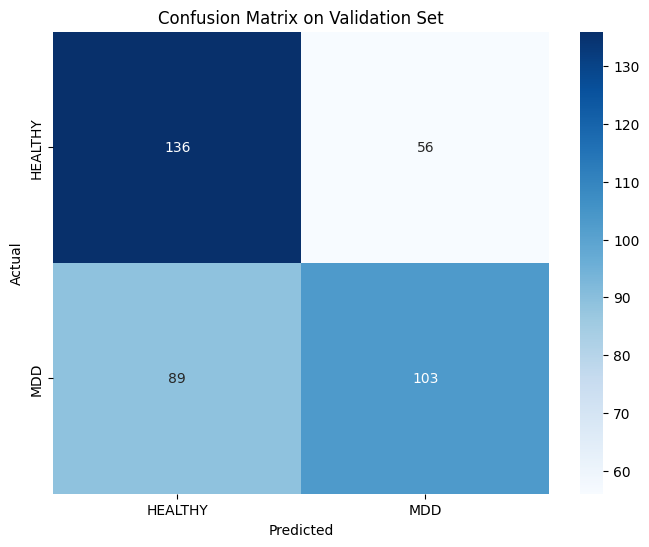

In [37]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the features dataframe
df_features = pd.read_pickle('/content/drive/MyDrive/TD-BRAIN/extracted_features/df_stat_features_SVM.pkl')

# Drop rows where 'diagnosis' is NaN
df_features = df_features.dropna(subset=['diagnosis'])

# Filter for male participants
df_features_female = df_features[df_features['gender'] == 1]

# Select only the first epoch for each male participant
df_ids_female = df_features_female[df_features_female['epoch'] == 1]

# Sample 16 healthy and 16 MDD male participants
healthy_female = df_ids_female[df_ids_female['diagnosis'] == 'HEALTHY'].sample(16, random_state=42)
mdd_female = df_ids_female[df_ids_female['diagnosis'] == 'MDD'].sample(16, random_state=42)

# Combine the healthy and MDD samples
df_ids_female_subsample = pd.concat([healthy_female, mdd_female])

# Get the subsample indices
df_ids_female_subsample_index = df_ids_female_subsample['ID'].tolist()

# Filter the original features dataframe to include only the subsampled male participants
df_subsample_female = df_features[df_features['ID'].isin(df_ids_female_subsample_index)]

# Verify the counts
diagnosis_counts = df_subsample_female['diagnosis'].value_counts()
print(diagnosis_counts)

# Data preprocessing
X = df_subsample_female.drop(columns=['ID', 'gender', 'diagnosis', 'epoch'])
y = df_subsample_female['diagnosis']

# Ensure groups are correctly defined
groups = df_subsample_female['ID'].values

# Print used features
used_features = X.columns.tolist()
print("Used Features:", used_features)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to balance the classes in the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Create a pipeline with scaler and a balanced SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced'))
])

# Define the parameter grid
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Use StratifiedGroupKFold to create folds while preserving group integrity
cv = StratifiedGroupKFold(n_splits=5)

# Use GridSearchCV to find the best parameters with stratified group k-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_res, y_res, groups=groups)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best parameters found:", grid_search.best_params_)

# Arrays to store metrics
train_acc_list = []
val_acc_list = []
train_precision_list = []
val_precision_list = []
train_recall_list = []
val_recall_list = []
train_f1_list = []
val_f1_list = []

# StratifiedGroupKFold cross-validation to evaluate the model on the training set
fold = 0
for train_idx, val_idx in cv.split(X_res, y_res, groups=groups):
    X_train, X_val = X_res[train_idx], X_res[val_idx]
    y_train, y_val = y_res[train_idx], y_res[val_idx]

    best_model.fit(X_train, y_train)

    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)

    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    val_precision = precision_score(y_val, y_val_pred, average='weighted')

    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    conf_matrix = confusion_matrix(y_val, y_val_pred)

    print(f"Fold {fold}:")
    print(f"Training Accuracy: {train_acc}")
    print(f"Validation Accuracy: {val_acc}")
    print(f"Training Precision: {train_precision}")
    print(f"Validation Precision: {val_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Append metrics to lists
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_precision_list.append(train_precision)
    val_precision_list.append(val_precision)
    train_recall_list.append(train_recall)
    val_recall_list.append(val_recall)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)

    fold += 1

# Calculate and print overall metrics
print("\nOverall Training Metrics:")
print(f"Accuracy: {np.mean(train_acc_list):.2f}")
print(f"Precision: {np.mean(train_precision_list):.2f}")
print(f"Recall: {np.mean(train_recall_list):.2f}")
print(f"F1 Score: {np.mean(train_f1_list):.2f}")

print("\nOverall Validation Metrics:")
print(f"Accuracy: {np.mean(val_acc_list):.2f}")
print(f"Precision: {np.mean(val_precision_list):.2f}")
print(f"Recall: {np.mean(val_recall_list):.2f}")
print(f"F1 Score: {np.mean(val_f1_list):.2f}")

# Generate a classification report for the validation set
y_val_pred = cross_val_predict(best_model, X_res, y_res, cv=cv, groups=groups)
report = classification_report(y_res, y_val_pred)
print("Validation Set Classification Report:")
print(report)

# Confusion matrix for the validation set
conf_matrix = confusion_matrix(y_res, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['HEALTHY', 'MDD'], yticklabels=['HEALTHY', 'MDD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()
